Loading models...

===== Processing: test1.jpg =====


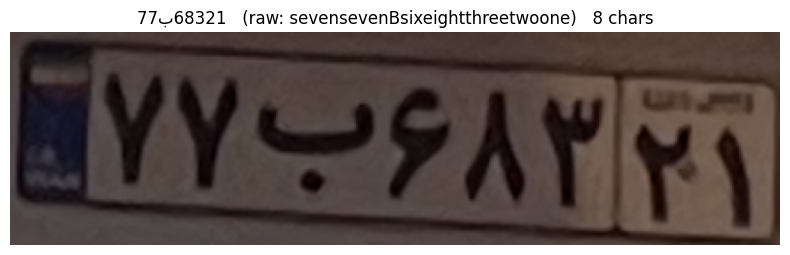

  Raw classes : sevensevenBsixeightthreetwoone
  Mapped text : 77ب68321
  Final plate : 77ب68321
  Char count  : 8
  Plate conf  : 0.760
  → Saved as: test1_plate1_77ب68321.jpg

===== Processing: test2.jpg =====


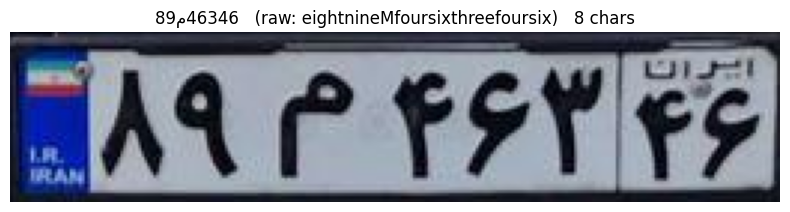

  Raw classes : eightnineMfoursixthreefoursix
  Mapped text : 89م46346
  Final plate : 89م46346
  Char count  : 8
  Plate conf  : 0.763
  → Saved as: test2_plate1_89م46346.jpg

===== Processing: test3.jpg =====


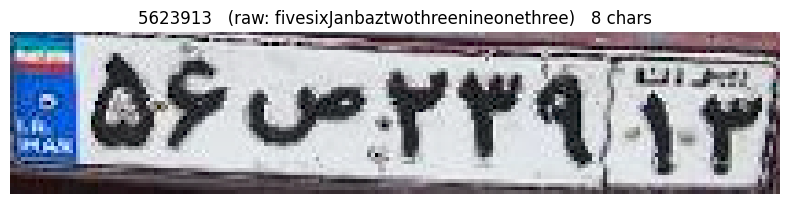

  Raw classes : fivesixJanbaztwothreenineonethree
  Mapped text : 5623913
  Final plate : 5623913
  Char count  : 8
  Plate conf  : 0.689
  → Saved as: test3_plate1_5623913.jpg

Processing complete ✓



In [1]:
import cv2
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# ************************************************************************************************************************************************
# ─── Configuration ──────────────────────────────────────────────────────────────
PLATE_MODEL = "models/best.pt"
CHAR_MODEL = "models/plate.pt"

CONF_PLATE = 0.55
CONF_CHAR = 0.35  # Lowered to detect faint digits like '9' and '3'

CROP_DIR = Path("plate_crops")
CROP_DIR.mkdir(parents=True, exist_ok=True)

IMAGES = [
    "photos/test1.jpg",
    "photos/test2.jpg",
    "photos/test3.jpg",
]


CLASS_TO_CHAR = {
    'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
    'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
    'Alef': 'الف', 'Ayn': 'ع', 'B': 'ب', 'D': 'د', 'Gh': 'ق',
    'J': 'ج', 'L': 'ل', 'M': 'م', 'N': 'ن', 'Sad': 'ص',  # ✅
    'Sin': 'س', 'Ta': 'ط', 'Te': 'ت', 'V': 'و', 'i': 'ی',
}

# Valid characters: digits + Persian letters
VALID_CHARS = set('0123456789ابپتجچحخدذرزژسشصضطظعغفقکگلمنوهی')
# ✅ Preprocessing: Grayscale + mild contrast enhancement (no binarization)
def preprocess_plate_crop(crop):
    """
    Convert to grayscale and apply mild CLAHE for better character visibility.
    Returns 3-channel BGR image (required by YOLO).
    """
    if crop is None or crop.size == 0:
        return crop

    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    # Mild CLAHE: avoids over-enhancement
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(6, 6))
    enhanced = clahe.apply(gray)
    # Convert back to 3-channel BGR
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)

def map_class_names_to_text(class_list):
    """Convert list of YOLO class names to a clean string using CLASS_TO_CHAR."""
    result = []
    for cls in class_list:
        char = CLASS_TO_CHAR.get(cls, None)
        if char is not None:
            result.append(char)
    return ''.join(result)

def filter_and_sort_chars(char_detections, crop_width, min_center_dist_ratio=0.04):
    """
    Sort characters left-to-right and filter duplicates using real crop width.
    """
    if not char_detections:
        return []

    with_center = [((box[0] + box[2]) / 2, box, name) for box, name in char_detections]
    with_center.sort(key=lambda x: x[0])

    min_dist = crop_width * min_center_dist_ratio
    filtered = []
    last_center = -10000

    for center_x, box, name in with_center:
        if center_x - last_center >= min_dist:
            filtered.append((box, name))
            last_center = center_x

    return filtered

def main():
    print("Loading models...")
    plate_model = YOLO(PLATE_MODEL)
    char_model = YOLO(CHAR_MODEL)

    for img_str in IMAGES:
        img_path = Path(img_str)
        if not img_path.exists():
            print(f"File not found: {img_path}")
            continue

        print(f"\n===== Processing: {img_path.name} =====")

        # Detect license plates
        results = plate_model(img_path, verbose=False)[0]
        img = cv2.imread(str(img_path))
        if img is None:
            print("Failed to read image!")
            continue

        plates = [b for b in results.boxes if float(b.conf) >= CONF_PLATE]
        if not plates:
            print("No plate detected with sufficient confidence.")
            continue

        for i, box in enumerate(plates, 1):
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = float(box.conf)

            crop = img[y1:y2, x1:x2]
            if crop.shape[0] < 35 or crop.shape[1] < 90:
                print(f"Plate {i} too small → skipped")
                continue

            crop_h, crop_w = crop.shape[:2]

            # ✅ Apply preprocessing: grayscale + CLAHE
            processed_crop = preprocess_plate_crop(crop)

            # Save temporary preprocessed image for character model
            temp_path = CROP_DIR / f"{img_path.stem}_plate{i}_temp.jpg"
            cv2.imwrite(str(temp_path), processed_crop)

            # Run character detection on ENHANCED image
            char_res = char_model(temp_path, verbose=False)[0]

            chars = []
            for b in char_res.boxes:
                if float(b.conf) < CONF_CHAR:
                    continue
                cls_name = char_res.names[int(b.cls)]
                box_xyxy = b.xyxy[0].cpu().numpy().astype(int)
                chars.append((box_xyxy, cls_name))

            if len(chars) < 3:
                print(f"Plate {i} → too few characters ({len(chars)})")
                temp_path.unlink(missing_ok=True)
                continue

            # Filter and sort using REAL crop width
            filtered_chars = filter_and_sort_chars(chars, crop_w, min_center_dist_ratio=0.04)

            if len(filtered_chars) < 3:
                print(f"Plate {i} → too few after filtering ({len(filtered_chars)})")
                temp_path.unlink(missing_ok=True)
                continue

            # Convert to final text
            class_names = [name for _, name in filtered_chars]
            raw = ''.join(class_names)
            mapped = map_class_names_to_text(class_names)
            final = ''.join(c for c in mapped if c in VALID_CHARS)[:10]  # Support full plate

            # Display ORIGINAL crop (for visual consistency)
            plt.figure(figsize=(8, 3))
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"{final}   (raw: {raw})   {len(filtered_chars)} chars")
            plt.tight_layout()
            plt.show()

            print(f"  Raw classes : {raw}")
            print(f"  Mapped text : {mapped}")
            print(f"  Final plate : {final}")
            print(f"  Char count  : {len(filtered_chars)}")
            print(f"  Plate conf  : {conf:.3f}")

            # Save ORIGINAL crop with final name
            try:
                safe_final = "".join(c if c.isalnum() else "_" for c in final)
                new_name = f"{img_path.stem}_plate{i}_{safe_final}.jpg"
                final_path = CROP_DIR / new_name
                cv2.imwrite(str(final_path), crop)
                temp_path.unlink(missing_ok=True)  # Clean up temp file
                print(f"  → Saved as: {new_name}")
            except Exception as e:
                print(f"  → Save failed: {e}")
                temp_path.unlink(missing_ok=True)

    print("\nProcessing complete ✓\n")

if __name__ == "__main__":
    main()